<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [BHPD2] - Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  A more advanced implementation of the precedent example
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('BHPD2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.5
Notebook id          : BHPD2
Run time             : Tuesday 26 January 2021, 11:05:48
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/tmp/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [2]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

### 2.2 - Option 2 : From a csv file
More fun !

In [3]:
data = pd.read_csv(f'{datasets_dir}/BHPD/origine/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [4]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.47,10.09,11.35,0.07,0.56,6.28,69.64,3.70,9.58,410.23,18.40,357.63,12.82
std,7.45,22.58,6.90,0.26,0.12,0.74,28.07,2.07,8.67,169.24,2.16,88.23,7.44
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,2.60,2.47
25%,0.09,0.00,5.40,0.00,0.45,5.88,46.83,2.05,4.00,279.50,17.40,374.69,7.18
50%,0.26,0.00,9.90,0.00,0.54,6.19,79.75,3.10,5.00,341.00,18.90,390.95,11.37
75%,3.69,0.00,18.10,0.00,0.62,6.62,94.47,5.00,24.00,666.00,20.20,396.23,17.10
max,73.53,100.00,27.74,1.00,0.87,8.70,100.00,12.13,24.00,711.00,22.00,396.90,37.97


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.46,-0.45,-1.58,-0.28,-1.48,-3.66,-2.38,-1.24,-0.99,-1.32,-2.68,-4.02,-1.39
25%,-0.45,-0.45,-0.86,-0.28,-0.89,-0.53,-0.81,-0.80,-0.64,-0.77,-0.46,0.19,-0.76
50%,-0.43,-0.45,-0.21,-0.28,-0.16,-0.11,0.36,-0.29,-0.53,-0.41,0.23,0.38,-0.20
75%,0.03,-0.45,0.98,-0.28,0.59,0.47,0.88,0.63,1.66,1.51,0.83,0.44,0.58
max,9.41,3.98,2.38,3.62,2.73,3.27,1.08,4.06,1.66,1.78,1.66,0.45,3.38


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [6]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5 - Train the model
### 5.1 - Get it

In [7]:
model=get_model_v1( (13,) )

model.summary()
# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [8]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [9]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100


 1/36 [..............................] - ETA: 0s - loss: 708.0176 - mae: 24.3400 - mse: 708.0176

36/36 [==============================] - 0s 5ms/step - loss: 537.8375 - mae: 21.1899 - mse: 537.8375 - val_loss: 373.7509 - val_mae: 17.5308 - val_mse: 373.7509


Epoch 2/100
 1/36 [..............................] - ETA: 0s - loss: 269.8658 - mae: 14.8471 - mse: 269.8658

35/36 [============================>.] - ETA: 0s - loss: 325.2315 - mae: 15.8201 - mse: 325.2315

36/36 [==============================] - 0s 3ms/step - loss: 323.1867 - mae: 15.7530 - mse: 323.1867 - val_loss: 161.4590 - val_mae: 10.7108 - val_mse: 161.4590


Epoch 3/100
 1/36 [..............................] - ETA: 0s - loss: 132.0110 - mae: 10.8902 - mse: 132.0110

36/36 [==============================] - 0s 3ms/step - loss: 129.6813 - mae: 9.0556 - mse: 129.6813 - val_loss: 64.5468 - val_mae: 5.9488 - val_mse: 64.5468


Epoch 4/100
 1/36 [..............................] - ETA: 0s - loss: 76.5010 - mae: 6.5137 - mse: 76.5010

36/36 [==============================] - 0s 2ms/step - loss: 56.4422 - mae: 5.5710 - mse: 56.4422 - val_loss: 38.6993 - val_mae: 4.3918 - val_mse: 38.6993


Epoch 5/100
 1/36 [..............................] - ETA: 0s - loss: 34.8021 - mae: 4.4828 - mse: 34.8021

36/36 [==============================] - 0s 2ms/step - loss: 34.0519 - mae: 4.1611 - mse: 34.0519 - val_loss: 29.9662 - val_mae: 4.0534 - val_mse: 29.9662


Epoch 6/100
 1/36 [..............................] - ETA: 0s - loss: 26.2483 - mae: 3.7735 - mse: 26.2483

36/36 [==============================] - 0s 2ms/step - loss: 25.4978 - mae: 3.5710 - mse: 25.4978 - val_loss: 23.2387 - val_mae: 3.4750 - val_mse: 23.2387


Epoch 7/100
 1/36 [..............................] - ETA: 0s - loss: 19.2170 - mae: 3.6746 - mse: 19.2170

36/36 [==============================] - 0s 2ms/step - loss: 22.5723 - mae: 3.3525 - mse: 22.5723 - val_loss: 21.1290 - val_mae: 3.3247 - val_mse: 21.1290


Epoch 8/100
 1/36 [..............................] - ETA: 0s - loss: 14.4488 - mae: 3.0017 - mse: 14.4488

36/36 [==============================] - 0s 2ms/step - loss: 19.9518 - mae: 3.1183 - mse: 19.9518 - val_loss: 19.1225 - val_mae: 3.1075 - val_mse: 19.1225


Epoch 9/100
 1/36 [..............................] - ETA: 0s - loss: 29.2202 - mae: 3.3824 - mse: 29.2202

36/36 [==============================] - 0s 2ms/step - loss: 18.6989 - mae: 2.9931 - mse: 18.6989 - val_loss: 23.7809 - val_mae: 3.7447 - val_mse: 23.7809


Epoch 10/100
 1/36 [..............................] - ETA: 0s - loss: 26.4030 - mae: 4.1290 - mse: 26.4030

36/36 [==============================] - 0s 2ms/step - loss: 17.2675 - mae: 2.9215 - mse: 17.2675 - val_loss: 22.3175 - val_mae: 3.5323 - val_mse: 22.3175


Epoch 11/100
 1/36 [..............................] - ETA: 0s - loss: 11.9258 - mae: 2.9241 - mse: 11.9258

36/36 [==============================] - 0s 2ms/step - loss: 16.3747 - mae: 2.8595 - mse: 16.3747 - val_loss: 18.8370 - val_mae: 3.1147 - val_mse: 18.8370


Epoch 12/100
 1/36 [..............................] - ETA: 0s - loss: 14.7442 - mae: 3.1106 - mse: 14.7442

36/36 [==============================] - 0s 2ms/step - loss: 15.6845 - mae: 2.8114 - mse: 15.6845 - val_loss: 16.7581 - val_mae: 2.8857 - val_mse: 16.7582


Epoch 13/100
 1/36 [..............................] - ETA: 0s - loss: 8.6752 - mae: 2.4503 - mse: 8.6752

36/36 [==============================] - 0s 2ms/step - loss: 14.7012 - mae: 2.6734 - mse: 14.7012 - val_loss: 17.7870 - val_mae: 3.0411 - val_mse: 17.7870


Epoch 14/100
 1/36 [..............................] - ETA: 0s - loss: 6.8471 - mae: 2.1432 - mse: 6.8471

36/36 [==============================] - 0s 2ms/step - loss: 14.0171 - mae: 2.6189 - mse: 14.0171 - val_loss: 17.4585 - val_mae: 2.9508 - val_mse: 17.4585


Epoch 15/100
 1/36 [..............................] - ETA: 0s - loss: 18.3990 - mae: 3.2548 - mse: 18.3990

36/36 [==============================] - 0s 2ms/step - loss: 13.2649 - mae: 2.5988 - mse: 13.2649 - val_loss: 16.0616 - val_mae: 2.8575 - val_mse: 16.0616


Epoch 16/100
 1/36 [..............................] - ETA: 0s - loss: 5.6929 - mae: 1.7750 - mse: 5.6929

36/36 [==============================] - 0s 2ms/step - loss: 12.9320 - mae: 2.5225 - mse: 12.9320 - val_loss: 15.2806 - val_mae: 2.6972 - val_mse: 15.2806


Epoch 17/100
 1/36 [..............................] - ETA: 0s - loss: 11.8435 - mae: 2.7357 - mse: 11.8435

36/36 [==============================] - 0s 2ms/step - loss: 12.3233 - mae: 2.4755 - mse: 12.3233 - val_loss: 15.7543 - val_mae: 2.7013 - val_mse: 15.7543


Epoch 18/100
 1/36 [..............................] - ETA: 0s - loss: 3.8158 - mae: 1.5768 - mse: 3.8158

36/36 [==============================] - 0s 2ms/step - loss: 12.0028 - mae: 2.4630 - mse: 12.0028 - val_loss: 14.1175 - val_mae: 2.4970 - val_mse: 14.1175


Epoch 19/100
 1/36 [..............................] - ETA: 0s - loss: 11.1040 - mae: 2.4605 - mse: 11.1040

36/36 [==============================] - 0s 2ms/step - loss: 11.6505 - mae: 2.3958 - mse: 11.6505 - val_loss: 15.4025 - val_mae: 2.6425 - val_mse: 15.4025


Epoch 20/100
 1/36 [..............................] - ETA: 0s - loss: 12.5761 - mae: 2.7012 - mse: 12.5761

36/36 [==============================] - 0s 2ms/step - loss: 11.3816 - mae: 2.4297 - mse: 11.3816 - val_loss: 14.3772 - val_mae: 2.5576 - val_mse: 14.3772


Epoch 21/100
 1/36 [..............................] - ETA: 0s - loss: 9.1389 - mae: 2.3340 - mse: 9.1389

36/36 [==============================] - 0s 2ms/step - loss: 11.1557 - mae: 2.3311 - mse: 11.1557 - val_loss: 15.2316 - val_mae: 2.6228 - val_mse: 15.2316


Epoch 22/100
 1/36 [..............................] - ETA: 0s - loss: 7.5503 - mae: 2.2118 - mse: 7.5503

36/36 [==============================] - 0s 2ms/step - loss: 10.7700 - mae: 2.2843 - mse: 10.7700 - val_loss: 14.0376 - val_mae: 2.4623 - val_mse: 14.0376


Epoch 23/100
 1/36 [..............................] - ETA: 0s - loss: 5.5638 - mae: 1.7387 - mse: 5.5638

36/36 [==============================] - 0s 2ms/step - loss: 10.6140 - mae: 2.2883 - mse: 10.6140 - val_loss: 14.1849 - val_mae: 2.4967 - val_mse: 14.1849


Epoch 24/100
 1/36 [..............................] - ETA: 0s - loss: 4.6123 - mae: 1.6717 - mse: 4.6123

36/36 [==============================] - 0s 2ms/step - loss: 10.3315 - mae: 2.2589 - mse: 10.3315 - val_loss: 15.7215 - val_mae: 2.7212 - val_mse: 15.7215


Epoch 25/100
 1/36 [..............................] - ETA: 0s - loss: 5.8510 - mae: 2.1248 - mse: 5.8510

36/36 [==============================] - 0s 2ms/step - loss: 10.0249 - mae: 2.2700 - mse: 10.0249 - val_loss: 13.7876 - val_mae: 2.4689 - val_mse: 13.7876


Epoch 26/100
 1/36 [..............................] - ETA: 0s - loss: 8.4378 - mae: 2.4217 - mse: 8.4378

36/36 [==============================] - 0s 2ms/step - loss: 9.7874 - mae: 2.1681 - mse: 9.7874 - val_loss: 13.8153 - val_mae: 2.4259 - val_mse: 13.8153


Epoch 27/100
 1/36 [..............................] - ETA: 0s - loss: 8.0397 - mae: 2.4659 - mse: 8.0397

36/36 [==============================] - 0s 2ms/step - loss: 9.7266 - mae: 2.1502 - mse: 9.7266 - val_loss: 15.9117 - val_mae: 2.6289 - val_mse: 15.9117


Epoch 28/100
 1/36 [..............................] - ETA: 0s - loss: 12.9662 - mae: 2.2371 - mse: 12.9662

36/36 [==============================] - 0s 2ms/step - loss: 9.6765 - mae: 2.1631 - mse: 9.6765 - val_loss: 14.5592 - val_mae: 2.5298 - val_mse: 14.5592


Epoch 29/100
 1/36 [..............................] - ETA: 0s - loss: 4.1695 - mae: 1.5506 - mse: 4.1695

36/36 [==============================] - 0s 2ms/step - loss: 9.5888 - mae: 2.1587 - mse: 9.5888 - val_loss: 13.8666 - val_mae: 2.4234 - val_mse: 13.8666


Epoch 30/100
 1/36 [..............................] - ETA: 0s - loss: 6.6638 - mae: 2.1498 - mse: 6.6638

36/36 [==============================] - 0s 2ms/step - loss: 9.4498 - mae: 2.1108 - mse: 9.4498 - val_loss: 15.0172 - val_mae: 2.5108 - val_mse: 15.0172


Epoch 31/100
 1/36 [..............................] - ETA: 0s - loss: 1.5878 - mae: 1.0485 - mse: 1.5878

36/36 [==============================] - 0s 2ms/step - loss: 9.3464 - mae: 2.1395 - mse: 9.3464 - val_loss: 14.1054 - val_mae: 2.4342 - val_mse: 14.1054


Epoch 32/100
 1/36 [..............................] - ETA: 0s - loss: 16.7570 - mae: 3.0722 - mse: 16.7570

36/36 [==============================] - 0s 2ms/step - loss: 9.0926 - mae: 2.0997 - mse: 9.0926 - val_loss: 13.2308 - val_mae: 2.3516 - val_mse: 13.2308


Epoch 33/100
 1/36 [..............................] - ETA: 0s - loss: 0.3957 - mae: 0.5253 - mse: 0.3957

36/36 [==============================] - 0s 2ms/step - loss: 9.1485 - mae: 2.0656 - mse: 9.1485 - val_loss: 14.0265 - val_mae: 2.4953 - val_mse: 14.0265


Epoch 34/100
 1/36 [..............................] - ETA: 0s - loss: 2.7144 - mae: 1.3836 - mse: 2.7144

36/36 [==============================] - 0s 2ms/step - loss: 8.9538 - mae: 2.0819 - mse: 8.9538 - val_loss: 14.0589 - val_mae: 2.4220 - val_mse: 14.0589


Epoch 35/100
 1/36 [..............................] - ETA: 0s - loss: 4.0216 - mae: 1.6289 - mse: 4.0216

36/36 [==============================] - 0s 2ms/step - loss: 8.6741 - mae: 2.0562 - mse: 8.6741 - val_loss: 13.0050 - val_mae: 2.4048 - val_mse: 13.0050


Epoch 36/100
 1/36 [..............................] - ETA: 0s - loss: 7.7254 - mae: 2.3590 - mse: 7.7254

36/36 [==============================] - 0s 2ms/step - loss: 8.7212 - mae: 2.0627 - mse: 8.7212 - val_loss: 13.2011 - val_mae: 2.3565 - val_mse: 13.2011


Epoch 37/100
 1/36 [..............................] - ETA: 0s - loss: 11.8881 - mae: 2.6282 - mse: 11.8881

36/36 [==============================] - 0s 2ms/step - loss: 8.5431 - mae: 2.0591 - mse: 8.5431 - val_loss: 13.8942 - val_mae: 2.3905 - val_mse: 13.8942


Epoch 38/100
 1/36 [..............................] - ETA: 0s - loss: 2.5369 - mae: 1.3958 - mse: 2.5369

36/36 [==============================] - 0s 2ms/step - loss: 8.3042 - mae: 2.0118 - mse: 8.3042 - val_loss: 14.1813 - val_mae: 2.5156 - val_mse: 14.1813


Epoch 39/100
 1/36 [..............................] - ETA: 0s - loss: 3.6958 - mae: 1.5786 - mse: 3.6958

36/36 [==============================] - 0s 2ms/step - loss: 8.4004 - mae: 2.0197 - mse: 8.4004 - val_loss: 14.0777 - val_mae: 2.4052 - val_mse: 14.0777


Epoch 40/100
 1/36 [..............................] - ETA: 0s - loss: 3.4145 - mae: 1.4783 - mse: 3.4145

36/36 [==============================] - 0s 2ms/step - loss: 8.2772 - mae: 2.0141 - mse: 8.2772 - val_loss: 13.6871 - val_mae: 2.5101 - val_mse: 13.6871


Epoch 41/100
 1/36 [..............................] - ETA: 0s - loss: 6.8318 - mae: 2.1699 - mse: 6.8318

36/36 [==============================] - 0s 2ms/step - loss: 8.2636 - mae: 1.9741 - mse: 8.2636 - val_loss: 13.6589 - val_mae: 2.4498 - val_mse: 13.6589


Epoch 42/100
 1/36 [..............................] - ETA: 0s - loss: 4.9865 - mae: 1.8356 - mse: 4.9865

36/36 [==============================] - 0s 2ms/step - loss: 8.0805 - mae: 1.9924 - mse: 8.0805 - val_loss: 13.6880 - val_mae: 2.4351 - val_mse: 13.6880


Epoch 43/100
 1/36 [..............................] - ETA: 0s - loss: 6.9380 - mae: 2.2673 - mse: 6.9380

36/36 [==============================] - 0s 2ms/step - loss: 8.1778 - mae: 2.0097 - mse: 8.1778 - val_loss: 13.9274 - val_mae: 2.5414 - val_mse: 13.9274


Epoch 44/100
 1/36 [..............................] - ETA: 0s - loss: 7.6202 - mae: 2.0598 - mse: 7.6202

36/36 [==============================] - 0s 2ms/step - loss: 7.8929 - mae: 1.9596 - mse: 7.8929 - val_loss: 12.5873 - val_mae: 2.3543 - val_mse: 12.5873


Epoch 45/100
 1/36 [..............................] - ETA: 0s - loss: 5.3809 - mae: 2.0346 - mse: 5.3809

36/36 [==============================] - 0s 2ms/step - loss: 7.9471 - mae: 1.9448 - mse: 7.9471 - val_loss: 13.1158 - val_mae: 2.3705 - val_mse: 13.1158


Epoch 46/100
 1/36 [..............................] - ETA: 0s - loss: 5.1117 - mae: 1.8457 - mse: 5.1117

36/36 [==============================] - 0s 2ms/step - loss: 7.8671 - mae: 1.9329 - mse: 7.8671 - val_loss: 12.9690 - val_mae: 2.3042 - val_mse: 12.9690


Epoch 47/100
 1/36 [..............................] - ETA: 0s - loss: 7.4026 - mae: 2.3631 - mse: 7.4026

36/36 [==============================] - 0s 2ms/step - loss: 7.5696 - mae: 1.9366 - mse: 7.5696 - val_loss: 13.2230 - val_mae: 2.4574 - val_mse: 13.2230


Epoch 48/100
 1/36 [..............................] - ETA: 0s - loss: 2.4101 - mae: 1.3461 - mse: 2.4101

36/36 [==============================] - 0s 2ms/step - loss: 7.3693 - mae: 1.9225 - mse: 7.3693 - val_loss: 13.4483 - val_mae: 2.3449 - val_mse: 13.4483


Epoch 49/100
 1/36 [..............................] - ETA: 0s - loss: 7.3577 - mae: 2.2303 - mse: 7.3577

36/36 [==============================] - 0s 2ms/step - loss: 7.5747 - mae: 1.9105 - mse: 7.5747 - val_loss: 13.2373 - val_mae: 2.3816 - val_mse: 13.2373


Epoch 50/100
 1/36 [..............................] - ETA: 0s - loss: 22.1598 - mae: 2.8860 - mse: 22.1598

36/36 [==============================] - 0s 2ms/step - loss: 7.4669 - mae: 1.9277 - mse: 7.4669 - val_loss: 12.4698 - val_mae: 2.2827 - val_mse: 12.4698


Epoch 51/100
 1/36 [..............................] - ETA: 0s - loss: 7.6647 - mae: 2.3585 - mse: 7.6647

36/36 [==============================] - 0s 2ms/step - loss: 7.4126 - mae: 1.9136 - mse: 7.4126 - val_loss: 12.7967 - val_mae: 2.3007 - val_mse: 12.7967


Epoch 52/100
 1/36 [..............................] - ETA: 0s - loss: 6.6841 - mae: 1.8651 - mse: 6.6841

36/36 [==============================] - 0s 2ms/step - loss: 7.4912 - mae: 1.8918 - mse: 7.4912 - val_loss: 13.2415 - val_mae: 2.3721 - val_mse: 13.2415


Epoch 53/100
 1/36 [..............................] - ETA: 0s - loss: 25.6787 - mae: 3.3779 - mse: 25.6787

36/36 [==============================] - 0s 2ms/step - loss: 7.3401 - mae: 1.8995 - mse: 7.3401 - val_loss: 12.7098 - val_mae: 2.3565 - val_mse: 12.7098


Epoch 54/100
 1/36 [..............................] - ETA: 0s - loss: 10.1976 - mae: 2.4170 - mse: 10.1976

36/36 [==============================] - 0s 2ms/step - loss: 7.1574 - mae: 1.8306 - mse: 7.1574 - val_loss: 13.6833 - val_mae: 2.5442 - val_mse: 13.6833


Epoch 55/100
 1/36 [..............................] - ETA: 0s - loss: 3.3518 - mae: 1.4800 - mse: 3.3518

36/36 [==============================] - 0s 2ms/step - loss: 7.1587 - mae: 1.8769 - mse: 7.1587 - val_loss: 12.6908 - val_mae: 2.4159 - val_mse: 12.6908


Epoch 56/100
 1/36 [..............................] - ETA: 0s - loss: 11.1812 - mae: 2.5203 - mse: 11.1812

36/36 [==============================] - 0s 2ms/step - loss: 7.2165 - mae: 1.8258 - mse: 7.2165 - val_loss: 12.6495 - val_mae: 2.3404 - val_mse: 12.6495


Epoch 57/100
 1/36 [..............................] - ETA: 0s - loss: 3.1343 - mae: 1.2883 - mse: 3.1343

36/36 [==============================] - 0s 2ms/step - loss: 6.8108 - mae: 1.8368 - mse: 6.8108 - val_loss: 13.0202 - val_mae: 2.3764 - val_mse: 13.0202


Epoch 58/100
 1/36 [..............................] - ETA: 0s - loss: 2.3965 - mae: 1.0410 - mse: 2.3965

36/36 [==============================] - 0s 2ms/step - loss: 6.8447 - mae: 1.8758 - mse: 6.8447 - val_loss: 12.9640 - val_mae: 2.3844 - val_mse: 12.9640


Epoch 59/100
 1/36 [..............................] - ETA: 0s - loss: 7.0635 - mae: 2.1455 - mse: 7.0635

36/36 [==============================] - 0s 2ms/step - loss: 6.9957 - mae: 1.8572 - mse: 6.9957 - val_loss: 12.8555 - val_mae: 2.3296 - val_mse: 12.8555


Epoch 60/100
 1/36 [..............................] - ETA: 0s - loss: 1.4058 - mae: 0.9211 - mse: 1.4058

36/36 [==============================] - 0s 2ms/step - loss: 6.5657 - mae: 1.8124 - mse: 6.5657 - val_loss: 12.2690 - val_mae: 2.2857 - val_mse: 12.2690


Epoch 61/100
 1/36 [..............................] - ETA: 0s - loss: 3.4388 - mae: 1.4765 - mse: 3.4388

36/36 [==============================] - 0s 2ms/step - loss: 6.5999 - mae: 1.7953 - mse: 6.5999 - val_loss: 12.2474 - val_mae: 2.3640 - val_mse: 12.2474


Epoch 62/100
 1/36 [..............................] - ETA: 0s - loss: 4.1985 - mae: 1.6036 - mse: 4.1985

36/36 [==============================] - 0s 2ms/step - loss: 6.6099 - mae: 1.7642 - mse: 6.6099 - val_loss: 12.5390 - val_mae: 2.3884 - val_mse: 12.5390


Epoch 63/100
 1/36 [..............................] - ETA: 0s - loss: 7.2697 - mae: 2.4947 - mse: 7.2697

36/36 [==============================] - 0s 2ms/step - loss: 6.4862 - mae: 1.8277 - mse: 6.4862 - val_loss: 12.5393 - val_mae: 2.3245 - val_mse: 12.5393


Epoch 64/100
 1/36 [..............................] - ETA: 0s - loss: 2.5746 - mae: 1.2740 - mse: 2.5746

36/36 [==============================] - 0s 2ms/step - loss: 6.4198 - mae: 1.7613 - mse: 6.4198 - val_loss: 13.6842 - val_mae: 2.3957 - val_mse: 13.6842


Epoch 65/100
 1/36 [..............................] - ETA: 0s - loss: 5.3844 - mae: 1.7560 - mse: 5.3844

36/36 [==============================] - 0s 2ms/step - loss: 6.3637 - mae: 1.7412 - mse: 6.3637 - val_loss: 13.2793 - val_mae: 2.3338 - val_mse: 13.2793


Epoch 66/100
 1/36 [..............................] - ETA: 0s - loss: 5.9346 - mae: 1.6049 - mse: 5.9346

36/36 [==============================] - 0s 2ms/step - loss: 6.2636 - mae: 1.7726 - mse: 6.2636 - val_loss: 12.9668 - val_mae: 2.3200 - val_mse: 12.9668


Epoch 67/100
 1/36 [..............................] - ETA: 0s - loss: 8.7173 - mae: 2.1909 - mse: 8.7173

36/36 [==============================] - 0s 2ms/step - loss: 6.2867 - mae: 1.7650 - mse: 6.2867 - val_loss: 13.3737 - val_mae: 2.3710 - val_mse: 13.3737


Epoch 68/100
 1/36 [..............................] - ETA: 0s - loss: 3.3311 - mae: 1.3425 - mse: 3.3311

36/36 [==============================] - 0s 2ms/step - loss: 6.1797 - mae: 1.7593 - mse: 6.1797 - val_loss: 12.0307 - val_mae: 2.2832 - val_mse: 12.0307


Epoch 69/100
 1/36 [..............................] - ETA: 0s - loss: 3.9111 - mae: 1.4117 - mse: 3.9111

36/36 [==============================] - 0s 2ms/step - loss: 6.4651 - mae: 1.7771 - mse: 6.4651 - val_loss: 12.2397 - val_mae: 2.3214 - val_mse: 12.2397


Epoch 70/100
 1/36 [..............................] - ETA: 0s - loss: 1.1011 - mae: 0.9641 - mse: 1.1011

36/36 [==============================] - 0s 2ms/step - loss: 6.2913 - mae: 1.7455 - mse: 6.2913 - val_loss: 12.9080 - val_mae: 2.3680 - val_mse: 12.9080


Epoch 71/100
 1/36 [..............................] - ETA: 0s - loss: 2.4270 - mae: 1.2445 - mse: 2.4270

36/36 [==============================] - 0s 2ms/step - loss: 6.0847 - mae: 1.7154 - mse: 6.0847 - val_loss: 11.9177 - val_mae: 2.2353 - val_mse: 11.9177


Epoch 72/100
 1/36 [..............................] - ETA: 0s - loss: 12.3730 - mae: 2.7309 - mse: 12.3730

36/36 [==============================] - 0s 2ms/step - loss: 5.8482 - mae: 1.7003 - mse: 5.8482 - val_loss: 11.9800 - val_mae: 2.3584 - val_mse: 11.9800


Epoch 73/100
 1/36 [..............................] - ETA: 0s - loss: 7.6617 - mae: 2.3681 - mse: 7.6617

36/36 [==============================] - 0s 2ms/step - loss: 6.0238 - mae: 1.7351 - mse: 6.0238 - val_loss: 14.2401 - val_mae: 2.5699 - val_mse: 14.2401


Epoch 74/100
 1/36 [..............................] - ETA: 0s - loss: 3.3728 - mae: 1.2274 - mse: 3.3728

36/36 [==============================] - 0s 2ms/step - loss: 5.9064 - mae: 1.7239 - mse: 5.9064 - val_loss: 12.5284 - val_mae: 2.3521 - val_mse: 12.5284


Epoch 75/100
 1/36 [..............................] - ETA: 0s - loss: 3.4484 - mae: 1.4781 - mse: 3.4484

36/36 [==============================] - 0s 2ms/step - loss: 5.8608 - mae: 1.7129 - mse: 5.8608 - val_loss: 12.9856 - val_mae: 2.4163 - val_mse: 12.9856


Epoch 76/100
 1/36 [..............................] - ETA: 0s - loss: 2.6239 - mae: 1.1080 - mse: 2.6239

36/36 [==============================] - 0s 2ms/step - loss: 5.8256 - mae: 1.7007 - mse: 5.8256 - val_loss: 13.3413 - val_mae: 2.4283 - val_mse: 13.3413


Epoch 77/100
 1/36 [..............................] - ETA: 0s - loss: 6.6166 - mae: 2.0045 - mse: 6.6166

36/36 [==============================] - 0s 2ms/step - loss: 5.7902 - mae: 1.6942 - mse: 5.7902 - val_loss: 12.8301 - val_mae: 2.3500 - val_mse: 12.8301


Epoch 78/100
 1/36 [..............................] - ETA: 0s - loss: 3.4865 - mae: 1.4235 - mse: 3.4865

36/36 [==============================] - 0s 2ms/step - loss: 5.5314 - mae: 1.6589 - mse: 5.5314 - val_loss: 13.5920 - val_mae: 2.3699 - val_mse: 13.5920


Epoch 79/100
 1/36 [..............................] - ETA: 0s - loss: 0.6828 - mae: 0.6668 - mse: 0.6828

36/36 [==============================] - 0s 2ms/step - loss: 5.5757 - mae: 1.7302 - mse: 5.5757 - val_loss: 11.6502 - val_mae: 2.2429 - val_mse: 11.6502


Epoch 80/100
 1/36 [..............................] - ETA: 0s - loss: 2.8948 - mae: 1.2464 - mse: 2.8948

36/36 [==============================] - 0s 2ms/step - loss: 5.5959 - mae: 1.6710 - mse: 5.5959 - val_loss: 12.8662 - val_mae: 2.3524 - val_mse: 12.8662


Epoch 81/100
 1/36 [..............................] - ETA: 0s - loss: 4.4004 - mae: 1.8574 - mse: 4.4004

36/36 [==============================] - 0s 2ms/step - loss: 5.4484 - mae: 1.6461 - mse: 5.4484 - val_loss: 14.2820 - val_mae: 2.5297 - val_mse: 14.2820


Epoch 82/100
 1/36 [..............................] - ETA: 0s - loss: 7.1577 - mae: 1.7312 - mse: 7.1577

36/36 [==============================] - 0s 2ms/step - loss: 5.3292 - mae: 1.6561 - mse: 5.3292 - val_loss: 12.7035 - val_mae: 2.5154 - val_mse: 12.7035


Epoch 83/100
 1/36 [..............................] - ETA: 0s - loss: 5.3531 - mae: 1.8256 - mse: 5.3531

36/36 [==============================] - 0s 2ms/step - loss: 5.3376 - mae: 1.6476 - mse: 5.3376 - val_loss: 12.6874 - val_mae: 2.4660 - val_mse: 12.6874


Epoch 84/100
 1/36 [..............................] - ETA: 0s - loss: 2.2913 - mae: 1.3012 - mse: 2.2913

36/36 [==============================] - 0s 2ms/step - loss: 5.2812 - mae: 1.6430 - mse: 5.2812 - val_loss: 12.7600 - val_mae: 2.3858 - val_mse: 12.7600


Epoch 85/100
 1/36 [..............................] - ETA: 0s - loss: 2.2834 - mae: 1.2217 - mse: 2.2834

36/36 [==============================] - 0s 2ms/step - loss: 5.4888 - mae: 1.6856 - mse: 5.4888 - val_loss: 12.6539 - val_mae: 2.3476 - val_mse: 12.6539


Epoch 86/100
 1/36 [..............................] - ETA: 0s - loss: 5.8355 - mae: 2.0482 - mse: 5.8355

36/36 [==============================] - 0s 2ms/step - loss: 5.2497 - mae: 1.6176 - mse: 5.2497 - val_loss: 11.6699 - val_mae: 2.2357 - val_mse: 11.6699


Epoch 87/100
 1/36 [..............................] - ETA: 0s - loss: 6.1751 - mae: 2.0722 - mse: 6.1751

36/36 [==============================] - 0s 2ms/step - loss: 5.1398 - mae: 1.6054 - mse: 5.1398 - val_loss: 12.0369 - val_mae: 2.3929 - val_mse: 12.0369


Epoch 88/100
 1/36 [..............................] - ETA: 0s - loss: 4.0589 - mae: 1.5536 - mse: 4.0589

36/36 [==============================] - 0s 2ms/step - loss: 5.1168 - mae: 1.5843 - mse: 5.1168 - val_loss: 11.5852 - val_mae: 2.2270 - val_mse: 11.5852


Epoch 89/100
 1/36 [..............................] - ETA: 0s - loss: 4.2984 - mae: 1.7413 - mse: 4.2984

36/36 [==============================] - 0s 2ms/step - loss: 4.9015 - mae: 1.6137 - mse: 4.9015 - val_loss: 12.1187 - val_mae: 2.4366 - val_mse: 12.1187


Epoch 90/100
 1/36 [..............................] - ETA: 0s - loss: 12.7976 - mae: 1.9028 - mse: 12.7976

36/36 [==============================] - 0s 2ms/step - loss: 4.8665 - mae: 1.5606 - mse: 4.8665 - val_loss: 15.2519 - val_mae: 2.6009 - val_mse: 15.2519


Epoch 91/100
 1/36 [..............................] - ETA: 0s - loss: 6.6535 - mae: 2.0568 - mse: 6.6535

36/36 [==============================] - 0s 2ms/step - loss: 5.1705 - mae: 1.6286 - mse: 5.1705 - val_loss: 13.2850 - val_mae: 2.3707 - val_mse: 13.2850


Epoch 92/100
 1/36 [..............................] - ETA: 0s - loss: 1.5029 - mae: 1.0787 - mse: 1.5029

36/36 [==============================] - 0s 2ms/step - loss: 5.1187 - mae: 1.5887 - mse: 5.1187 - val_loss: 11.8848 - val_mae: 2.2974 - val_mse: 11.8848


Epoch 93/100
 1/36 [..............................] - ETA: 0s - loss: 6.4396 - mae: 1.8832 - mse: 6.4396

36/36 [==============================] - 0s 2ms/step - loss: 4.7854 - mae: 1.5438 - mse: 4.7854 - val_loss: 12.8263 - val_mae: 2.3866 - val_mse: 12.8263


Epoch 94/100
 1/36 [..............................] - ETA: 0s - loss: 2.8374 - mae: 1.2201 - mse: 2.8374

36/36 [==============================] - 0s 2ms/step - loss: 4.6870 - mae: 1.5416 - mse: 4.6870 - val_loss: 13.2347 - val_mae: 2.5382 - val_mse: 13.2347


Epoch 95/100
 1/36 [..............................] - ETA: 0s - loss: 9.4396 - mae: 2.5367 - mse: 9.4396

36/36 [==============================] - 0s 2ms/step - loss: 4.9903 - mae: 1.5629 - mse: 4.9903 - val_loss: 11.7711 - val_mae: 2.2457 - val_mse: 11.7711


Epoch 96/100
 1/36 [..............................] - ETA: 0s - loss: 2.1902 - mae: 1.0458 - mse: 2.1902

36/36 [==============================] - 0s 2ms/step - loss: 4.6655 - mae: 1.5398 - mse: 4.6655 - val_loss: 12.3467 - val_mae: 2.3698 - val_mse: 12.3467


Epoch 97/100
 1/36 [..............................] - ETA: 0s - loss: 6.0663 - mae: 1.8891 - mse: 6.0663

36/36 [==============================] - 0s 2ms/step - loss: 4.6368 - mae: 1.5071 - mse: 4.6368 - val_loss: 11.6750 - val_mae: 2.2501 - val_mse: 11.6750


Epoch 98/100
 1/36 [..............................] - ETA: 0s - loss: 3.7548 - mae: 1.4248 - mse: 3.7548

36/36 [==============================] - 0s 2ms/step - loss: 4.6304 - mae: 1.5311 - mse: 4.6304 - val_loss: 11.7970 - val_mae: 2.3192 - val_mse: 11.7970


Epoch 99/100
 1/36 [..............................] - ETA: 0s - loss: 2.5398 - mae: 1.3573 - mse: 2.5398

36/36 [==============================] - 0s 2ms/step - loss: 4.5894 - mae: 1.5283 - mse: 4.5894 - val_loss: 11.2752 - val_mae: 2.2551 - val_mse: 11.2752


Epoch 100/100
 1/36 [..............................] - ETA: 0s - loss: 4.4567 - mae: 1.9337 - mse: 4.4567

36/36 [==============================] - 0s 2ms/step - loss: 4.5993 - mae: 1.5317 - mse: 4.5993 - val_loss: 11.7914 - val_mae: 2.2495 - val_mse: 11.7914


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 11.7914
x_test / mae       : 2.2495
x_test / mse       : 11.7914


### 6.2 - Training history
What was the best result during our training ?

In [11]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.2270


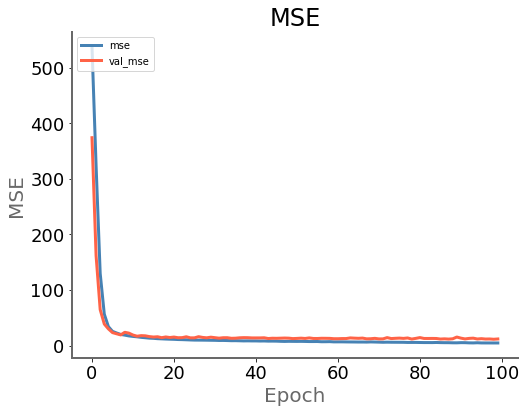

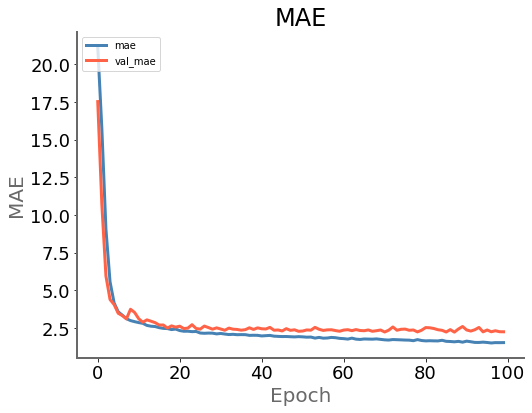

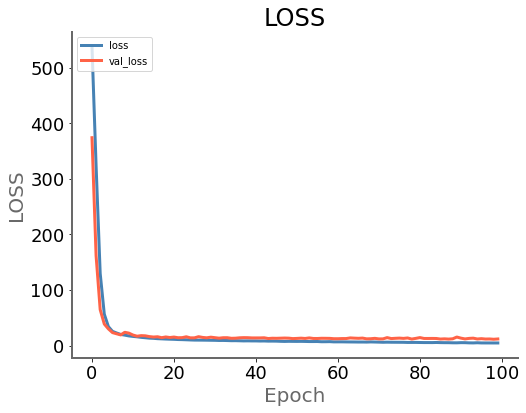

In [12]:
pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [13]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 11.2752
x_test / mae       : 2.2551
x_test / mse       : 11.2752


### 7.3 - Make a prediction

In [15]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [16]:
predictions = loaded_model.predict( my_data )
print("Prediction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], real_price))

Prediction : 11.86 K$   Reality : 10.40 K$


In [17]:
pwk.end()

End time is : Tuesday 26 January 2021, 11:05:57
Duration is : 00:00:10 715ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>